In [1]:
import matplotlib.pyplot as plt
from skimage.exposure import rescale_intensity
from skimage import io, filters, color, measure
from skimage.feature import peak_local_max
from scipy import ndimage 
import numpy as np
import xlrd
import freud.box
from freud import box, density
from scipy import stats
import os
%matplotlib inline
    
def get_dots2(file,microns=2,compare=False,size=2,spacing=5):
    image = color.rgb2gray(io.imread(file))
    i1 = filters.gaussian(image,sigma=.7)
    i1 = ndimage.maximum_filter(i1,size=size,mode='constant')
    coordinates = peak_local_max(i1, min_distance=spacing,indices=False)
    if compare:
        io.imshow(image -coordinates)
    label_img = measure.label(coordinates)
    centroids = []
    for region in measure.regionprops(label_img):
        centroids.append(region.centroid)
    scaled = microns*np.asarray(centroids)/image.shape - [microns/2,microns/2]
    return np.append(scaled,np.zeros((len(scaled),1)),axis=1)

def plot_rdf(dots,L,plot=False):
    box = freud.box.Box(L,L,is2D=True)
    box.periodic=[True,True,False]
    rdf = freud.density.RDF(20,.49,normalize=True)
    rdf.compute(system=(box,dots),reset=True)
    if plot:
        plt.scatter(rdf.bin_centers, rdf.rdf)
        plt.xlabel("r (μm)")
        plt.ylabel("<g(r)>")
        plt.show()
    return rdf.bin_centers, rdf.rdf

def plot_ldf(dots, L, dr=0.01, axis = 1,sw=0.05):
    # count distances ALONG axis
    # slice image along normal
    dots = dots[:,0:2]
    bins = np.arange(0,L,dr)
    #tot = np.zeros( (len(np.arange(0,L,sw)), len(bins) )) 
    tot = []
    if axis==1:
        normal = 0
    else:
        normal =1
    tmp = np.zeros(len(bins))
    for lr, s in enumerate(np.arange(0,L,sw)):
        sel1 = dots[dots[:,normal]>s]
        sel = sel1[sel1[:,normal]<=s+sw]
        if len(sel)<=1:
            continue
        for i, di in enumerate(sel[:-1]):
            for j, dj in enumerate(sel[i+1:]):
                r = di[axis]-dj[axis]
                if r>L/2:
                    r=r-L
                if r< -L/2:
                    r=r+L
                index = int(np.absolute(r)//dr)
                #print(r,L,index)
                tmp[index] = tmp[index]+1
        tot.append(tmp/len(sel)*(len(sel)-1)*dr)
    halfrange = int(len(bins)//2)
    tot = np.asarray(tot)
    ldf = np.mean(tot,axis=0)
    std = stats.sem(tot,axis=0,ddof=1)
    return bins[:halfrange], ldf[:halfrange], std[:halfrange]

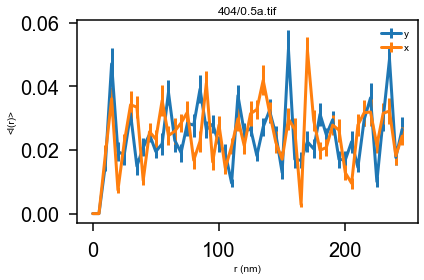

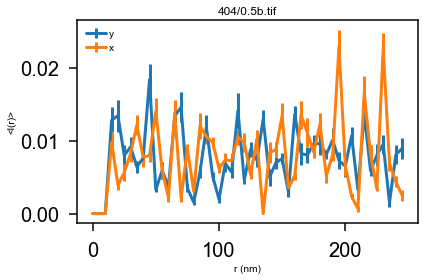

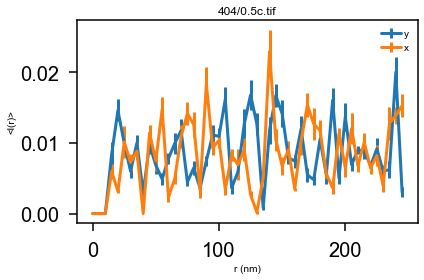

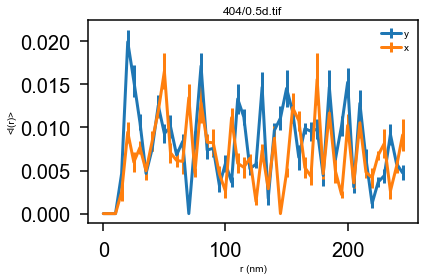

In [2]:
#404
sw = 0.01
dr = 0.005 #microns
L=.5
#files = ["404/0.5a.tif","404/0.5b.tif","404/0.5c.tif","404/0.5d.tif","405/0.5a.tif","405/0.5b.tif","405/0.5c.tif","405/0.5d.tif","404/0.5a.tif","406/0.5b.tif","406/0.5c.tif","406/0.5d.tif"]
#params = [(5,10),(5,15),(5,15),(5,15),(5,10),(5,15),(5,15),(5,15),(5,10),(5,15),(5,15),(5,15)]
files = ["404/0.5a.tif","404/0.5b.tif","404/0.5c.tif","404/0.5d.tif"]
params = [(5,10),(5,15),(5,15),(5,15)]#,(5,10),(5,15),(5,15),(5,15),(5,10),(5,15),(5,15),(5,15)]

x = []
y = []
for f,p in zip(files,params):
    dots=get_dots2(f,compare=False,microns=L,size=p[0], spacing=p[1]) #size 5, spacing 10-15 seems reasonable
    bins,ldf,std = plot_ldf(dots,L,sw=sw,dr=dr,axis=1)
    bins2,ldf2,std2 = plot_ldf(dots,L,sw=sw,dr=dr,axis=0)
    x.append(ldf2)
    y.append(ldf)
    plt.errorbar(1000*bins, ldf,yerr=std,label="y")
    plt.errorbar(1000*bins, ldf2,yerr=std2,label='x')
    plt.title(f)
    plt.xlabel("r (nm)")
    plt.ylabel("<l(r)>")
    plt.legend()
    plt.show()

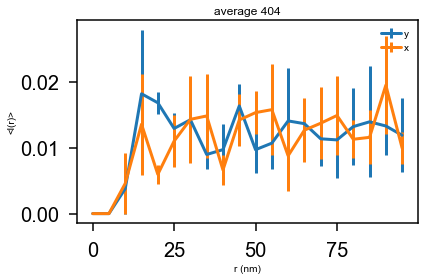

In [3]:
#404
stop = 20
x = np.asarray(x)
y = np.asarray(y)
xerr = stats.sem(x,axis=0,ddof=1)
yerr = stats.sem(y,axis=0,ddof=1)
x = np.mean(x,axis=0)
y = np.mean(y,axis=0)
plt.errorbar(1000*bins[:stop], y[:stop],label="y",yerr=yerr[:stop])
plt.errorbar(1000*bins2[:stop], x[:stop],label='x',yerr=xerr[:stop])
plt.title("average 404")
plt.xlabel("r (nm)")
plt.ylabel("<l(r)>")
plt.legend()
plt.show()

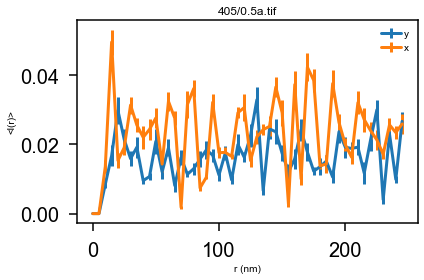

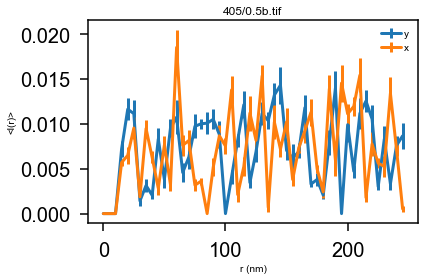

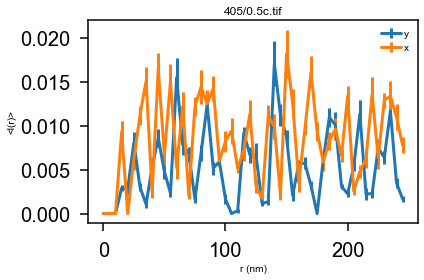

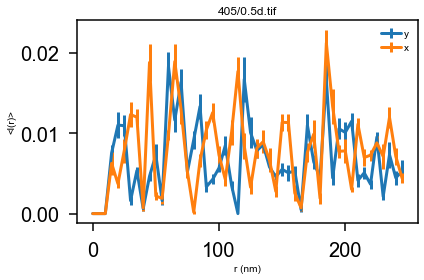

In [4]:
sw = 0.01
dr = 0.005 #microns
L=.5
#files = ["404/0.5a.tif","404/0.5b.tif","404/0.5c.tif","404/0.5d.tif","405/0.5a.tif","405/0.5b.tif","405/0.5c.tif","405/0.5d.tif","404/0.5a.tif","406/0.5b.tif","406/0.5c.tif","406/0.5d.tif"]
#params = [(5,10),(5,15),(5,15),(5,15),(5,10),(5,15),(5,15),(5,15),(5,10),(5,15),(5,15),(5,15)]
files = ["405/0.5a.tif","405/0.5b.tif","405/0.5c.tif","405/0.5d.tif"]
params = [(5,10),(5,15),(5,15),(5,15)]#,(5,10),(5,15),(5,15),(5,15)]

x = []
y = []
for f,p in zip(files,params):
    dots=get_dots2(f,compare=False,microns=L,size=p[0], spacing=p[1]) #size 5, spacing 10-15 seems reasonable
    bins,ldf,std = plot_ldf(dots,L,sw=sw,dr=dr,axis=1)
    bins2,ldf2,std2 = plot_ldf(dots,L,sw=sw,dr=dr,axis=0)
    x.append(ldf2)
    y.append(ldf)
    plt.errorbar(1000*bins, ldf,yerr=std,label="y")
    plt.errorbar(1000*bins, ldf2,yerr=std2,label='x')
    plt.title(f)
    plt.xlabel("r (nm)")
    plt.ylabel("<l(r)>")
    plt.legend()
    plt.show()

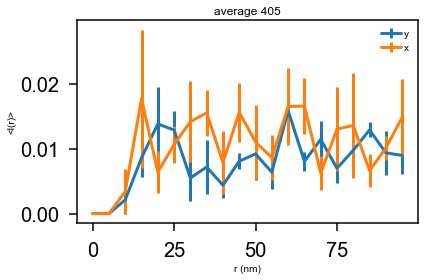

In [5]:
#405
stop = 20
x = np.asarray(x)
y = np.asarray(y)
xerr = stats.sem(x,axis=0,ddof=1)
yerr = stats.sem(y,axis=0,ddof=1)
x = np.mean(x,axis=0)
y = np.mean(y,axis=0)
plt.errorbar(1000*bins[:stop], y[:stop],label="y",yerr=yerr[:stop])
plt.errorbar(1000*bins2[:stop], x[:stop],label='x',yerr=xerr[:stop])
plt.title("average 405")
plt.xlabel("r (nm)")
plt.ylabel("<l(r)>")
plt.legend()
plt.show()

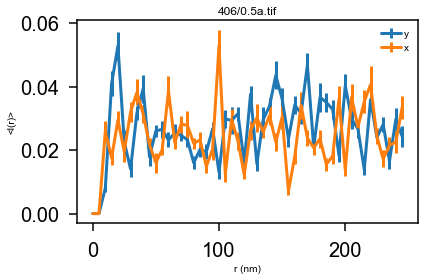

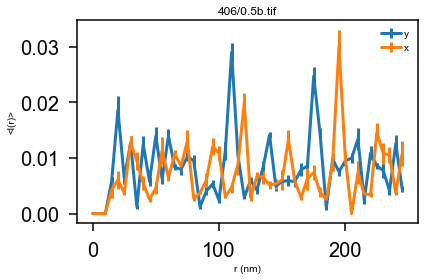

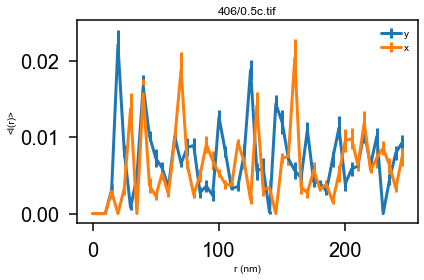

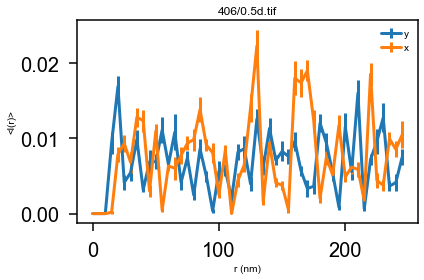

In [6]:
#406
sw = 0.01
dr = 0.005 #microns
L=.5
#files = ["404/0.5a.tif","404/0.5b.tif","404/0.5c.tif","404/0.5d.tif","405/0.5a.tif","405/0.5b.tif","405/0.5c.tif","405/0.5d.tif","404/0.5a.tif","406/0.5b.tif","406/0.5c.tif","406/0.5d.tif"]
#params = [(5,10),(5,15),(5,15),(5,15),(5,10),(5,15),(5,15),(5,15),(5,10),(5,15),(5,15),(5,15)]
files = ["406/0.5a.tif","406/0.5b.tif","406/0.5c.tif","406/0.5d.tif"]
params = [(5,10),(5,15),(5,15),(5,15)]

x = []
y = []
for f,p in zip(files,params):
    dots=get_dots2(f,compare=False,microns=L,size=p[0], spacing=p[1]) #size 5, spacing 10-15 seems reasonable
    bins,ldf,std = plot_ldf(dots,L,sw=sw,dr=dr,axis=1)
    bins2,ldf2,std2 = plot_ldf(dots,L,sw=sw,dr=dr,axis=0)
    x.append(ldf2)
    y.append(ldf)
    plt.errorbar(1000*bins, ldf,yerr=std,label="y")
    plt.errorbar(1000*bins, ldf2,yerr=std2,label='x')
    plt.title(f)
    plt.xlabel("r (nm)")
    plt.ylabel("<l(r)>")
    plt.legend()
    plt.show()

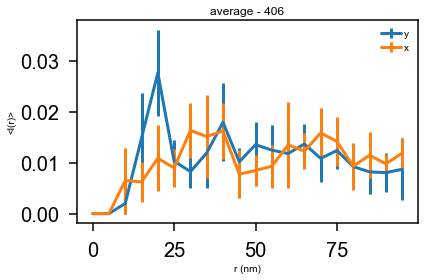

In [7]:
#406
stop = 20
x = np.asarray(x)
y = np.asarray(y)
xerr = stats.sem(x,axis=0,ddof=1)
yerr = stats.sem(y,axis=0,ddof=1)
x = np.mean(x,axis=0)
y = np.mean(y,axis=0)
plt.errorbar(1000*bins[:stop], y[:stop],label="y",yerr=yerr[:stop])
plt.errorbar(1000*bins2[:stop], x[:stop],label='x',yerr=xerr[:stop])
plt.title("average - 406")
plt.xlabel("r (nm)")
plt.ylabel("<l(r)>")
plt.legend()
plt.show()